In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.utils import Sequence


from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor

import random

In [2]:
TARGET_SIZE = (144, 256)

In [3]:
def parse_filename(filename):
    components = filename.split("_")
    offset = 0
    
    if "-" in components[1]:
        offset = 1
    
    if len(components) < 6 + offset:
        return False, []
   
    x = int(components[1 + offset])
    y = int(components[2 + offset])
    z = int(components[3 + offset])
    r = int(components[4 + offset])
    is_flying = int(components[5 + offset].split(".")[0])

    if x == 0 and y == 0 and z == 0 and r == 0:
        return False, []

    # flip the z and x due to data-record error
    return True, [z, y, x, r, is_flying]

In [4]:
image_data = []
label_data = []

for date_folder in os.listdir("data"):
    date_folder_path = os.path.join("data", date_folder)

    if os.path.isdir(date_folder_path):
        for filename in os.listdir(date_folder_path):
            if filename.endswith(".png"):
                image_path = os.path.join(date_folder_path, filename)
                valid, components = parse_filename(filename)
                
                if valid:
                    image_data.append(image_path)
                    label_data.append(components)

In [5]:
label_tuples = [tuple(label) for label in label_data]
label_counter = Counter(label_tuples)

In [6]:
max_occurrences = max(label_counter.values())
min_occurrences = 100

f_label_data = []
f_image_data = []

for label, image in zip(label_data, image_data):
    occurrences = label_counter[tuple(label)]
    if occurrences >= min_occurrences:
        duplicate_factor = max_occurrences // occurrences
        f_label_data.extend([label] * duplicate_factor)
        f_image_data.extend([image] * duplicate_factor)

In [7]:
f_label_tuples = [tuple(label) for label in f_label_data]
f_label_counter = Counter(f_label_tuples)

sorted_labels = sorted(f_label_counter.items(), key=lambda x: x[1], reverse=True)

In [8]:
tokenizer = {label: idx for idx, (label, _) in enumerate(sorted_labels)}
detokenizer = {idx: label for idx, (label, _) in enumerate(sorted_labels)}

tokenized_labels = [tokenizer[tuple(label)] for label in f_label_data]

In [9]:
print(len(label_data), len(image_data), len(f_label_data), len(f_image_data))

5708 5708 29693 29693


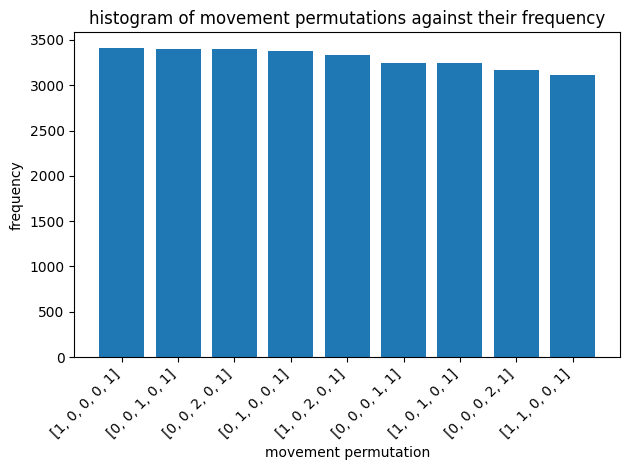

In [10]:
frequencies, bins = np.histogram(tokenized_labels, bins=len(sorted_labels))

plt.bar(range(len(sorted_labels)), frequencies)

plt.xlabel("movement permutation")
plt.ylabel("frequency")
plt.title("histogram of movement permutations against their frequency")

num_of_labels = 1

x_labels = [f"[{x}, {y}, {z}, {r}, {is_flying}]" for (x, y, z, r, is_flying), _ in sorted_labels]
plt.xticks(range(0, len(sorted_labels), num_of_labels), x_labels[::num_of_labels], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [11]:
def preprocess_image(image_path):
    image = load_img(image_path, target_size=TARGET_SIZE) 
    image = img_to_array(image) / 255.0

    return image

In [12]:
def preprocess_and_cache_images(image_paths, cache_folder, max_workers):
    os.makedirs(cache_folder, exist_ok=True)
    cached_images = []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for image_path in image_paths:
            cached_path = os.path.join(cache_folder, os.path.basename(image_path) + '.npy')
            if os.path.exists(cached_path):
                cached_images.append(np.load(cached_path))
            else:
                image = preprocess_image(image_path)
                np.save(cached_path, image)
                cached_images.append(cached_path)

    return cached_images

In [13]:
print(len(label_data), len(image_data), len(f_label_data), len(f_image_data))

5708 5708 29693 29693


In [14]:
f_image_data = preprocess_and_cache_images(f_image_data, "cached_downscales", max_workers=os.cpu_count())
one_hot_labels = tf.keras.utils.to_categorical(tokenized_labels, num_classes=len(f_label_counter))

In [15]:
print(len(label_data), len(image_data), len(f_label_data), len(f_image_data))

5708 5708 29693 29693


In [16]:
image_train, image_val, label_train, label_val = train_test_split(
    f_image_data, one_hot_labels, test_size=0.2, random_state=42)

In [17]:
# make a CNN
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(len(f_label_counter), activation="softmax"))

In [18]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.array(batch_x), np.array(batch_y)


In [19]:
training_generator = DataGenerator(image_train, label_train, 64)
validating_generator = DataGenerator(image_val, label_val, 64)

In [20]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# model.fit(
#     image_train,
#     label_train,
#     epochs=10,
#     batch_size=10,
#     validation_data=(image_val, label_val)
# )

model.fit(training_generator, epochs=10, validation_data=validating_generator)

Epoch 1/10
372/372 [==============================] - 14s 34ms/step - loss: 1.3377 - accuracy: 0.7981 - val_loss: 0.1018 - val_accuracy: 0.9744
Epoch 2/10
372/372 [==============================] - 12s 33ms/step - loss: 0.0547 - accuracy: 0.9865 - val_loss: 0.0740 - val_accuracy: 0.9798
Epoch 3/10
372/372 [==============================] - 13s 34ms/step - loss: 0.0169 - accuracy: 0.9966 - val_loss: 0.0559 - val_accuracy: 0.9860
Epoch 4/10
372/372 [==============================] - 13s 34ms/step - loss: 0.0126 - accuracy: 0.9971 - val_loss: 0.1054 - val_accuracy: 0.9715
Epoch 5/10
372/372 [==============================] - 13s 34ms/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.0412 - val_accuracy: 0.9894
Epoch 6/10
372/372 [==============================] - 13s 34ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.0559 - val_accuracy: 0.9848
Epoch 7/10
372/372 [==============================] - 13s 35ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0512 - val_accuracy:

In [22]:
def predict(filename, from_folder=False):
    image = None

    if from_folder:
        image = preprocess_image(filename)

    image = np.expand_dims(image or filename, axis=0)

    if not from_folder:
        plt.imshow(image[0])

    predictions = model.predict(image)[0]
    predictions = np.argmax(predictions)

    result = detokenizer[predictions]

    return result


1/1 [==============================] - 0s 16ms/step
(0, 1, 0, 0, 1)


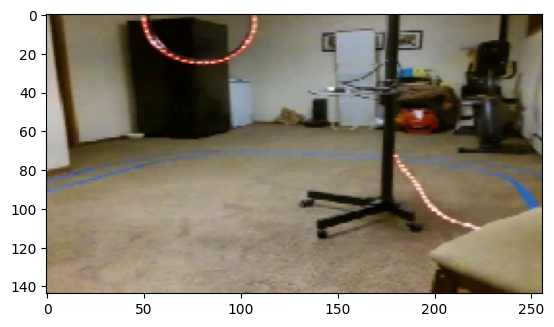

In [52]:
predictions = predict(image_val[random.randint(0, len(image_val))], from_folder=False)

print(predictions)